In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers
from transformers import TrainingArguments, set_seed

from data import SharedTaskData
from models import MultitaskModel
from train_mtl import Tokenize, compute_metrics, prepare_data
from trainers import MultitaskTrainer, NLPDataCollator, TASK_NAMES

In [2]:
# Set variables.
checkpoint: str = "../../Downloads/checkpoint-470"
use_model: str = "roberta-large-mnli"
seed: int = 0
tensorflows: bool = False

In [3]:
# Load dataset.
set_seed(seed)
tokenize = Tokenize(use_model, tensorflows, "concatenation")
torch.backends.cudnn.deterministic = True

train_data = SharedTaskData("TaskA_train.csv")
dev_data = SharedTaskData("TaskA_dev.csv")

tokenized_train_dataset_novelty, tokenized_dev_dataset_novelty = prepare_data(
    use_model,
    train_data,
    dev_data,
    "novelty",
    tokenize.tokenize_function_nov
)
tokenized_train_dataset_validity, tokenized_dev_dataset_validity = prepare_data(
    use_model,
    train_data,
    dev_data,
    "validity",
    tokenize.tokenize_function_val
)

if "ArgumentRelation" in use_model:
    kwargs = {'pad_token_id': 1}
else:
    kwargs = {}

# Load model.
multitask_model = MultitaskModel.create(
    model_name=use_model,
    model_type_dict={
        "novelty": transformers.AutoModelForSequenceClassification,
        "validity": transformers.AutoModelForSequenceClassification,
    },
    model_config_dict={
        "novelty": transformers.AutoConfig.from_pretrained(use_model, num_labels=2, **kwargs),
        "validity": transformers.AutoConfig.from_pretrained(use_model, num_labels=2, **kwargs),
    },
    tensorflows=tensorflows
)

multitask_model.load_trainer_checkpoint(checkpoint)

# Load trainer/evaluator.
val_dataset = {
    "novelty": tokenized_dev_dataset_novelty,
    "validity": tokenized_dev_dataset_validity,
}

train_dataset = {
    "novelty": tokenized_train_dataset_novelty,
    "validity": tokenized_train_dataset_validity,
}

training_args = TrainingArguments(
    f"hftrainer_am_mtl_{use_model}_{seed}",
    label_names=['labels']
)

trainer = MultitaskTrainer(
    model=multitask_model,
    data_collator=NLPDataCollator(tokenizer=tokenize.tokenizer),
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenize.tokenizer,
    compute_metrics=compute_metrics,
    args=training_args,
)

Parameter 'function'=<function map_label at 0x7ff53ef85160> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initi

  0%|          | 0/750 [00:00<?, ?ex/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/202 [00:00<?, ?ex/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/750 [00:00<?, ?ex/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/202 [00:00<?, ?ex/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [4]:
# Get predictions on validation set.
outputs = trainer.predict(val_dataset)

for task in TASK_NAMES:
    print(f"{task}: Amount of mistakes: {torch.sum(outputs[task]['predictions'] != torch.tensor(outputs[task]['labels']))}")

***** Running Prediction *****
  Num examples = 202
  Batch size = 8
***** Running Prediction *****
  Num examples = 202
  Batch size = 8


Evaluating novelty
Evaluating validity
novelty: Amount of mistakes: 50
validity: Amount of mistakes: 49


/Users/urjakhurana/miniconda3/envs/argmining2022/lib/python3.8/site-packages/pandas/core/indexing.py:1503: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  key = np.asarray(key)
/Users/urjakhurana/miniconda3/envs/argmining2022/lib/python3.8/site-packages/pandas/core/indexing.py:1503: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.asarray(key)


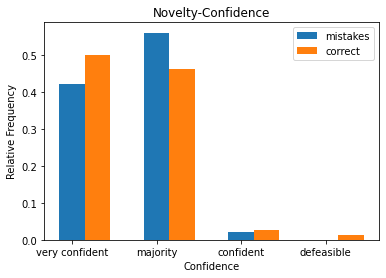

In [5]:
# Get (mis-)classification of predictions based on confidence of annotation.
%matplotlib inline
task = "novelty"

# Retrieve confidences of the mistakes and correct classifications.
idxs = (outputs[task]['predictions'] != torch.tensor(outputs[task]['labels'])).nonzero()
confs_mistakes = dev_data.df.iloc[list(idxs)][f"{task.capitalize()}-Confidence"]
idxs = (outputs[task]['predictions'] == torch.tensor(outputs[task]['labels'])).nonzero()
confs_correct = dev_data.df.iloc[list(idxs)][f"{task.capitalize()}-Confidence"]

# Normalize over the total count of mistakes and corrects respectively.
confs_mistakes = {k: v / confs_mistakes.count() for k, v in confs_mistakes.value_counts().to_dict().items()}
confs_correct = {k: v / confs_correct.count() for k, v in confs_correct.value_counts().to_dict().items()}

# Uncomment if background is black so text of plot is white.
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)
# plt.title(f"{task.capitalize()}-Confidence", color="w")

np.random.seed(0)
plt.xticks(range(len(list(confs_correct.keys()))), list(confs_correct.keys()))
plt.xlabel('Confidence')
plt.ylabel('Relative Frequency')
plt.title(f"{task.capitalize()}-Confidence")

width = 0.3
plt.bar(range(len(confs_correct.keys())), [confs_mistakes.get(k, 0) for k in confs_correct.keys()], label="mistakes", width=width)
plt.bar(np.arange(len(confs_correct)) + width, confs_correct.values(), label="correct", width=width)
plt.legend()
plt.show()


In [6]:
# Get distribution of mistakes over combined labels.
task = "validity"

idxs = (outputs[task]['predictions'] != torch.tensor(outputs[task]['labels'])).nonzero()
val_mistakes = dev_data.df.iloc[list(idxs)]["Validity"]
nov_mistakes = dev_data.df.iloc[list(idxs)]["Novelty"]

counts = defaultdict(int)
for val_mistake, nov_mistake in zip(val_mistakes, nov_mistakes):
    if val_mistake == -1 and nov_mistake == -1:
        counts["non-valid;non-novel"] += 1
    elif val_mistake == 1 and nov_mistake == -1:
        counts["valid;non-novel"] += 1
    elif val_mistake == -1 and nov_mistake == 1:
        counts["non-valid;novel"] += 1
    elif val_mistake == 1 and nov_mistake == 1:
        counts["valid;novel"] += 1

counts = {k: v / len(val_mistakes) for k, v in counts.items()}
print(counts)

{'non-valid;non-novel': 0.14285714285714285, 'non-valid;novel': 0.22448979591836735, 'valid;non-novel': 0.40816326530612246, 'valid;novel': 0.20408163265306123}


/Users/urjakhurana/miniconda3/envs/argmining2022/lib/python3.8/site-packages/pandas/core/indexing.py:1503: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  key = np.asarray(key)
/Users/urjakhurana/miniconda3/envs/argmining2022/lib/python3.8/site-packages/pandas/core/indexing.py:1503: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  key = np.asarray(key)


In [7]:
# Get percentage of mistakes per topic.
task = "novelty"
idxs = (outputs[task]['predictions'] != torch.tensor(outputs[task]['labels'])).nonzero()
topics_mistakes = dev_data.df.iloc[list(idxs)]["topic"]

topics_mistakes.value_counts() / dev_data.df["topic"].value_counts()

Vegetarianism                                   0.200000
Video surveillance                              0.473684
War on Drugs                                    0.188406
Warrantless wiretapping in the United States    0.260870
Wave power                                      0.217391
Wind energy                                     0.208333
Yucca Mountain nuclear waste repository         0.235294
Zoos                                            0.571429
Name: topic, dtype: float64